### Summery
<pre>
Author           : Anjana Tiha
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images by retraining pretrained model “InceptionV3” 
                      with 5856 images of X-ray (1.15GB).
                   2. For retraining removed output layers, freezed first few layers and Fine-tuned model for 
                      two new label classes (Pneumonia and Normal).
                   3. Attained testing accuracy 83.44% and loss 0.42.
Method           : 
Tools/Library    : Python, Keras, PyTorch, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.0
Last Update      : 11.30.2018
Comments         : Please use Anaconda editor for convenience of visualization.
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitHub)</a>
GitLab Link      : <a href=https://gitlab.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitLab)</a>
Portfolio        : <a href=https://anjanatiha.wixsite.com/website>Anjana Tiha's Portfolio</a>
</pre>

#### Dataset
<pre>
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>Chest X-Ray Images (Pneumonia) Dataset (Kaggle)</a>
                 : <a href=https://data.mendeley.com/datasets/rscbjbr9sj/2>Chest X-Ray Images (Pneumonia) Dataset (Original Dataset)</a>
Original Paper   : <a href=https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5>Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning</a>
                   (Daniel S. Kermany, Michael Goldbaum, Wenjia Cai, M. Anthony Lewis, Huimin Xia, Kang Zhang)
                   https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
</pre>

#### Library/Tools Version
- Python - v3.6.7
- argparse
- random
- numpy
- shutil
- gc
- re
- Keras - 2.2.4
- Keras-preprocessing - v1.0.5
- TensorFlow - 1.12
- PIL/Pillow - 5.1.0
- Matplotlib - 2.2.2
- scikit-learn - 0.19.1
- mlxtend - 0.14.0

#### Commands / Running Instruction
<pre>
tensorboard --logdir=logs
%config IPCompleter.greedy=True
</pre>

<pre>
<b>Dataset Details</b>
Dataset Name            : Chest X-Ray Images (Pneumonia)
Number of Class         : 2
Number/Size of Images   : Total      : 5856 (1.15 Gigabyte (GB))
                          Training   : 5216 (1.07 Gigabyte (GB))
                          Validation : 320  (42.8 Megabyte (MB))
                          Testing    : 320  (35.4 Megabyte (MB))

<b>Model Parameters</b>
Machine Learning Library: Keras
Base Model              : InceptionV3
Optimizers              : Adam
Loss Function           : categorical_crossentropy

<b>Training Parameters</b>
Batch Size              : 64
Number of Epochs        : 50
Training Time           : 3 Hours

<b>Output (Prediction/ Recognition / Classification Metrics)</b>
<!--<b>Validation</b>-->
<b>Testing</b>
Accuracy                : 83.44%
Loss                    : 0.42
<!--Precision               : -->
Recall                  : 94% (highest)
<!--Specificity             : -->
</pre>

## Import Libraries

In [ ]:
from __future__ import print_function

import argparse
import sys
import os

import random

import time
import datetime

from collections import Counter
import numpy as np

import shutil
import inspect

import gc

import re

import keras
from keras import models
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend as K

import tensorflow as tf

from IPython.display import display
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix



## Functions

### File Function

In [21]:
# Makes directory, if directory exists removes if remove parameter is set to True 
def mk_reset_dir(directory, remove=False):
    if remove and os.path.exists(directory):
        try:
            shutil.rmtree(directory)
            os.mkdir(directory)
        except:
            print("Could not remove directory : ", directory)
            return False
    else:
        try:
            os.mkdir(directory)
        except:
            print("Could not create directory: ", directory)
            return False
        
    return True

### Time Function

In [22]:
# print time with date, month, year and hour, minute, second in format given by parameter
def date_time(x):
    if x==1:
        print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==2:    
        print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==3:  
        print('Date now: %s' % datetime.datetime.now())
    if x==4:  
        print('Date today: %s' % datetime.date.today())  

### Debug Functions

In [23]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)  

### String Function

In [24]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

### Data Visualization Function

In [25]:
# count number of files in each subdirectory of a directory
def count_bar(master_directory):
    dir_list = os.listdir(master_directory)
    num_class = len(dir_list)

    dir_name = []
    dir_file_count = []

    for directory in dir_list:
        cur_dir = os.path.join(master_directory, directory)
        count_sample = len(os.listdir(cur_dir))
        dir_name.append(directory)
        dir_file_count.append(count_sample)
    
    return dir_name, dir_file_count
               

# show barplot
def bar_plot(x, y, title, xlabel, ylabel, figsize=(10,8), title_fontsize = 14, label_fontsize=12, subplot_no=0):
    if subplot_no:
        plt.subplot(subplot_no)
    sns.barplot(x=x, y=y)
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(range(len(x)), x)
    

# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, title, xlabel, ylabel, figsize=(10,8), title_fontsize = 14, label_fontsize=12, subplot_no=0):
    dir_name, dir_file_count = count_bar(master_directory)
    x=dir_name
    y=dir_file_count
    bar_plot(x, y, title, xlabel, ylabel, figsize=fig_size, title_fontsize=title_fontsize, label_fontsize=label_fontsize, subplot_no=subplot_no)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, title, xlabel, ylabel, figsize=(10,8), title_fontsize = 14, label_fontsize=12):
    plt.figure(figsize=fig_size)
    count_bar_plot(training_dir, title +" (Training)", xlabel, ylabel, fig_size, title_fontsize, label_fontsize, subplot_no=131)
    count_bar_plot(validation_dir, title +" (Validation)", xlabel, ylabel, fig_size, title_fontsize, label_fontsize, subplot_no=132)
    count_bar_plot(testing_dir, title +" (Testing)", xlabel, ylabel, fig_size, title_fontsize, label_fontsize, subplot_no=133)
    plt.show()

### Image Preprocessing Function

In [26]:
# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)
def get_transformed_image_batch(directory, target_size, classes, class_mode='categorical', batch_size=1, shuffle=True, rescale=None, shear_range=0.0, zoom_range=0.0, horizontal_flip=False, validation_split=0.0):       
    datagen = ImageDataGenerator(
            rescale=rescale,
            shear_range=shear_range,
            zoom_range=zoom_range,
            horizontal_flip=horizontal_flip,
            validation_split=validation_split)     
    
    image_generator = datagen.flow_from_directory(
            directory,
            target_size=target_size,
            classes = classes,
            class_mode=class_mode,
            batch_size=batch_size)
    return image_generator

### Data Label Preprocessing Function

In [27]:
# adjust class weights for imbalanced dataset of classes of images
def get_class_weight(y):
    counter = Counter(y)                          
    max_val = float(max(counter.values()))     
    class_weight = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
    return class_weight

### Tensorflow Graph Function

In [28]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    try:
        del model
    except:
        return False
    tf.reset_default_graph()
    K.clear_session()
    gc.collect()
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint=None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

In [29]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

def basic_model(optimizer, loss, metrics, input_shape=(3,150,150), activation='relu', activation2='sigmoid', padding="same", padding2="valid", pool_size=(2, 2), dilation_rate=(2, 2)):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation=activation, padding=padding, input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), padding=padding, activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(32, (3, 3), activation=activation, padding=padding, input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding=padding, activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(64, (3, 3), activation=activation, padding=padding))
    model.add(Conv2D(64, (3, 3), padding=padding, activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(96, (3, 3), dilation_rate=dilation_rate, activation=activation, padding=padding))
    model.add(Conv2D(96, (3, 3), padding2=padding2, activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(128, (3, 3), dilation_rate=dilation_rate, activation=activation, padding=padding))
    model.add(Conv2D(128, (3, 3), padding2=padding2, activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Flatten())

    model.add(Dense(64, activation=swish_activation))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation=activation2))

    model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

    print(model.summary())

In [30]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

### Model Initialization Function
#### Load and Configure Model Function InceptionV3 for Fine-Tuning with New Class Labels
<p>1. Imports Pretrained model InceptionV3 <br>
   2. Disabled training on first few layers <br>
   3. Enabled training on top and output layers<br>
   4. Adjust output Dense Layer to number of Image Classes <br>
</p>

In [31]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_inception_model(train_generator, validation_generator, epochs, verbose, optimizer, loss, metrics, tensorboard, callbacks, num_class, include_top=False, non_trainable_index=249, print_layers = False):    
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=include_top)

    # add a global spatial average pooling layer
    # Setting model layers specially output layer with class number
    x = base_model.output
    
    x = Dropout(0.5)(x)
    
    x = GlobalAveragePooling2D()(x)
    
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    
    # and a logistic layer -- let's say we have 2 classes

    # softmax for multi-class
    predictions = Dense(num_class, activation='softmax')(x) 
    
    # sigmoid for 2 class or binary class
    # predictions = Dense(num_class, activation='sigmoid')(x) 

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
     
    # compile model with loss, optimizer and metrics 
    model.compile(optimizer, loss=loss, metrics=metrics)

    
    if callbacks:
        tensorboard.set_model(model) 
    
    # train the model on the new data for a few epochs
    model.fit_generator(train_generator,
                        steps_per_epoch = len(train_generator),
                        epochs=epochs,
                        # verbose=verbose, 
                        callbacks=callbacks,
                        validation_data=validation_generator,
                        validation_steps=len(validation_generator),
                        class_weight = class_weight)

    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    if print_layers:
        for i, layer in enumerate(base_model.layers):
            print(i, layer.name)

    # Freeze or set first few layers as untrainable
    # Unfreeze or set rest of the layers as trainable
    for layer in model.layers[:non_trainable_index]:
        layer.trainable = False
    for layer in model.layers[non_trainable_index:]:
        layer.trainable = True
        
    model.summary()
        
    return model


### Training Performance Visualization Function

In [32]:
# Plot training & validation performance
def plot_history(history, plot_val, title, xlabel, ylabel, legend=[['Train', 'Val'], ['Train', 'Val']], fig_size=(10,8), title_fontsize = 14, label_fontsize=12):
    plt.figure(figsize=fig_size)
    
    plt.subplot(121)
    plt.plot(history.history[plot_val[0][0]])
    plt.plot(history.history[plot_val[0][1]])
    plt.title(title[0], fontsize=title_fontsize)
    plt.ylabel(ylabel[0], fontsize=label_fontsize)
    plt.xlabel(xlabel[0], fontsize=label_fontsize)
    plt.legend(legend[0], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history[plot_val[1][0]])
    plt.plot(history.history[plot_val[1][1]])
    plt.title(title[1], fontsize=title_fontsize)
    plt.ylabel(ylabel[1], fontsize=label_fontsize)
    plt.xlabel(xlabel[1], fontsize=label_fontsize)
    plt.legend(legend[1], loc='upper left')
    plt.show()

### Testing Performance Report Function

In [33]:
def predict_report(model, test_generator, classes, print_report=False):
    y_preds = model.predict_generator(test_generator, steps=len(test_generator))
    y_classes = y_preds.argmax(axis=-1)

    CM = confusion_matrix(test_generator.classes, y_classes)
    CM_report = classification_report(test_generator.classes, y_classes, target_names=classes)
    
    if print_report: 
        print(CM_report)
    return y_preds, y_classes, CM, CM_report

def model_evaluate(model, test_generator, print_report=False):
    result = model.evaluate_generator(generator=test_generator, steps=len(test_generator))
    
    accuracy = result[1]*100
    loss = result[0]
    
    if print_report:
        print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
        print("%s%.2f"% ("Loss: ", loss))
    
    return accuracy, loss

### Performance Metrics Function

In [34]:
# reverse classification report for reporting negetive classes (0)
def reverse_pos_neg(CM, print_bool):
    tp=CM[0][0]
    fp=CM[0][1]
    fn=CM[1][0]
    tn=CM[1][1]
    if print_bool:
        print(tp, fp, tn, fn, tn)
    return [tp, fp, tn, fn, tn]

# reverse and report classification report for reporting negetive classes (0)
def report(CM, reverse):
    if not reverse:
        tn, fp, fn, tp = CM.ravel()

    else:
        tp=CM[0][0]
        fp=CM[0][1]
        fn=CM[1][0]
        tn=CM[1][1]
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    print("Recall of the model is {:.2f}".format(recall))
    print("Precision of the model is {:.2f}".format(precision))
    
    return precision, recall

### Testing Function

In [65]:
def test_all_models(model_dir, details, report_type, classes):
    results = {}
    
    model_files = os.listdir(model_dir)
    
    i=0
    model = None
    
    for model_file in model_files:
        
        model_path = model_dir+"\\"+model_file
        
        if not os.path.isdir(model_path):
            reset_graph(model)

            model = keras.models.load_model(model_path)

            if report_type=="Complete":
                y_preds, y_classes, CM, CM_report = predict_report(model, test_generator, classes)
                results[model_file] = [CM, CM_report]

            else:
                accuracy, loss =  model_evaluate(model, test_generator, print_report=False)

                results[model_file] = [accuracy, loss]


            if details:
                print("%s%s"%("Model No: ", i+1))
                print("%s%s"%("Model File: ", model_file))
                print("*"*80)
                if report_type=="Complete":
                    show_confusion_matrix(test_generator, y_classes, classes)
                    print(CM_report)
                else:
                    print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
                    print("%s%.2f"% ("Loss: ", loss))

                print("-"*80)
                print("-"*80)

            elif not details and i%10==0:
                print("%s%s"%("Model No: ", i+1))
                print("%s%s"%("Model File: ", model_file))
                print("*"*80)
                if report_type=="Complete":
                    show_confusion_matrix(test_generator, y_classes, classes)
                    print(CM_report)
                else:
                    print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
                    print("%s%.2f"% ("Loss: ", loss))
                print("-"*80)
                print("-"*80)

            i+=1
    print("Test complete")
    
    return results

### Testing Visualization Function

In [36]:
def line_plot_over_epochs(array, title, xlabel="Epoch", ylabel="Value", title_fontsize=14, label_fontsize=12, subplot_no=0):
    x_axis_arr = np.arange(len(array))
    if subplot_no:
        plt.subplot(subplot_no)
    plt.title(title, fontsize=title_fontsize)
    plt.plot(x_axis_arr, array)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    
def line_plot_over_epochs_loss_acc(array, title, fig_size=(10, 8), xlabel=["Epoch", "Epoch"], ylabel=["Value","Value"], title_fontsize=14, label_fontsize=12):
    plt.figure(figsize=fig_size)
    line_plot_over_epochs(array[0], title[0], xlabel=xlabel[0], ylabel=ylabel[0], title_fontsize=title_fontsize, label_fontsize=label_fontsize, subplot_no=121)
    line_plot_over_epochs(array[1], title[1], xlabel=xlabel[1], ylabel=ylabel[1], title_fontsize=title_fontsize, label_fontsize=label_fontsize, subplot_no=122)
    plt.show()
    
def show_confusion_matrix(test_generator, y_classes, classes, figsize=(10,8), stick_fontsize=12):
    CM = confusion_matrix(test_generator.classes, y_classes)
    fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=figsize, hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(len(classes)), classes, fontsize=stick_fontsize)
    plt.yticks(range(len(classes)), classes, fontsize=stick_fontsize)
    plt.show()
    return CM

# Preprocessing

### Reset Graph

In [37]:
reset_graph(model)

NameError: name 'model' is not defined

### Set Path for Train, Validation and Test Dataset

In [38]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory+ r"train"
testing_dir = input_directory+ r"test"
validation_dir = input_directory+ r"val"

### Data Visualization

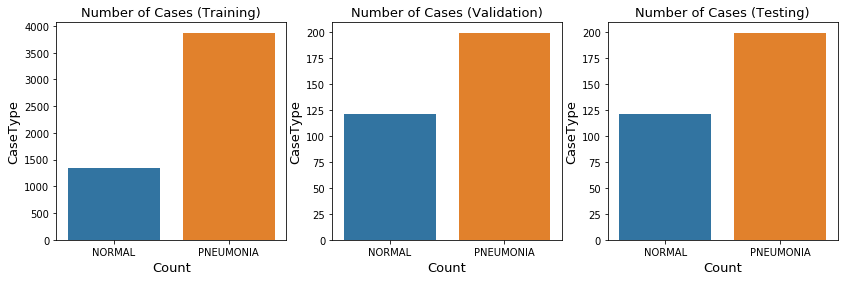

In [39]:
xlabel="Count"
ylabel="CaseType"
fig_size = (14,4)
# fig_size = (4,2)
# title_fontsize=14
title_fontsize=13
# label_fontsize=12
label_fontsize=13
title="Number of Cases"


show_train_val_test(training_dir, validation_dir, testing_dir, title, xlabel, ylabel, figsize=fig_size, title_fontsize = title_fontsize, label_fontsize=label_fontsize)


### Preprocessing (Image Preprocessing)
#### Configuring Image Transformation Parameters for Training, Validation, Testing and  Dataset 

In [40]:
# Get number of label/ class / category
num_class = len(os.listdir(training_dir))
print(num_class)


#Image Augmentation/ Preprocessing before training
norm=255.0
rescale=1./norm
# shear_range=0.2
shear_range=0.1
# zoom_range=0.2
zoom_range=0.1
horizontal_flip=True


# flow from directory function
# Target Image dimention
target_size=(224, 224)

# Batch size
# train
# batch_size=32
batch_size=64
# batch_size=128

# validation
validation_batch_size=1
# test
test_batch_size=1

# shuffle
# test
test_shuffle=False

# validation split for train
validation_split=0.0

# class mode
# class_mode='binary'
class_mode='categorical'
# class_mode='sparse'


classes = ['Normal', 'PNEUMONIA']

2


### Image Transformation for Training, Validation, Testing and  Dataset 

In [41]:
train_generator = get_transformed_image_batch(training_dir, target_size, classes, class_mode=class_mode, batch_size=batch_size, rescale=rescale, shear_range=shear_range, zoom_range=zoom_range, horizontal_flip=horizontal_flip)       

validation_generator = get_transformed_image_batch(validation_dir, target_size, classes, class_mode=class_mode, batch_size=validation_batch_size, rescale=rescale)       

test_generator = get_transformed_image_batch(validation_dir, target_size, classes, class_mode=class_mode, batch_size=test_batch_size, shuffle = test_shuffle, rescale=rescale) 

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


### Weight Adjustmanet for Class Label Imbalance

In [42]:
y=train_generator.classes
class_weight=get_class_weight(y)
# class_weight=None

##  Model and Training Configuration

In [54]:
# setting model and log output directory
model_dir=output_directory + r"models/"+time.strftime('%Y%m%d%H%M%S')+"/"
log_dir=output_directory + r"logs"+time.strftime('%Y%m%d%H%M%S')+"/"

mk_reset_dir(model_dir, remove=True)
mk_reset_dir(log_dir, remove=True)



# make or reset directory
# mk_reset_dir(model_dir, False)
# mk_reset_dir(log_dir, False)

init_model_file=model_dir+"base-"+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
model_file=model_dir+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
retrain_model_file=model_dir+"retrain-{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"


## Custom Model Configuration

In [55]:
input_shape=(3,150,150)
activation='relu'
activation2='sigmoid'
padding="same"
padding2="valid"
pool_size=(2, 2)
dilation_rate=(2, 2)

##  Base Model and Training Configuration for Fine-Tuning

In [56]:
##### Base Model - InceptionV3 (pretrained) initial training settings

# inception base top layer discarded
include_top=False

# number of layers freezed
non_trainable_index = 249

# init_optimizer=optimizers.Adam()
init_optimizer=optimizers.Adam(0.000001)

print_layers=False

# initial epochs on only output layers
# init_epochs=1
# initial_epochs=3
init_epochs=15

# verbose
init_verbose=0

# callbacks
init_callbacks=None

# model report
print_layers=True


### Full model training parameter configuration for Loss, Optimizer and Performance Metrics

# optimizer
# adam lr=0.01/0.001/0.0001/0.00001/0.000001, decay = decay=1e-5/ 1e-6
# optimizer=optimizers.Adam()
# optimizer=Adam(lr=0.0001, decay=1e-5)
# optimizer=optimizers.Adam(0.000001, decay=1e-7)
optimizer=optimizers.Adam(0.1)
optimizer=optimizers.Adam(0.00001, decay=1e-7)



# loss function
# loss='binary_crossentropy'
loss='categorical_crossentropy'


# performance metrics ('accuracy', 'binary_accuracy', precision, recall)
# metrics=['accuracy']
metrics=['mae', 'acc']


### Main model training parameter configuration

# epochs = 20/30/50
epochs = 30

# steps
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

# verbose 0=nothing 1=each line
verbose=0


#### Configuration for Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard

# checkpoint
ck_monitor='val_acc'
ck_verbose=0
ck_save_best_only=False
ck_save_weights_only=False
ck_mode='auto'
ck_period=1


# ReduceLROnPlateau
red_lr_monitor='val_loss'
red_lr_factor=0.1 # default
red_lr_patience=10
red_lr_patience=2
red_lr_verbose=1
red_lr_mode='auto'
red_lr_min_delta=0.0001
red_lr_cooldown=0
red_lr_min_lr=0.0

# early_stopping
es_monitor = 'val_loss'
es_min_delta=0
# es_patience=0
es_patience=5
es_verbose=0
es_mode='auto'
es_baseline=None


# tensorboard
tb_histogram_freq=0
tb_batch_size=batch_size
tb_write_graph=True
tb_write_grads=False
tb_write_images=False
tb_embeddings_freq=0
tb_embeddings_layer_names=None
tb_embeddings_metadata=None
tb_embeddings_data=None
update_freq='epoch'

### Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard

In [57]:
checkpoint = ModelCheckpoint(model_file, monitor=ck_monitor, verbose=ck_verbose, save_best_only=ck_save_best_only, save_weights_only=ck_save_weights_only, mode=ck_mode, period=ck_period)

reduce_lr = ReduceLROnPlateau(monitor=red_lr_monitor, factor=red_lr_factor, patience=red_lr_patience, verbose=red_lr_verbose, mode=red_lr_mode, min_delta=red_lr_min_delta, cooldown=red_lr_cooldown, min_lr=red_lr_min_lr)

early_stopping = EarlyStopping(monitor=es_monitor, min_delta=es_min_delta, patience=es_patience, verbose=es_verbose, mode=es_mode, baseline=es_baseline)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=tb_histogram_freq, batch_size=tb_batch_size, write_graph=tb_write_graph, write_grads=tb_write_grads, write_images=tb_write_images, embeddings_freq=tb_embeddings_freq, embeddings_layer_names=tb_embeddings_layer_names, embeddings_metadata=tb_embeddings_metadata, embeddings_data=tb_embeddings_data)

In [58]:
# callbacks - checkpoint, reduce_lr, early_stopping, tensorboard
init_callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
callbacks = [checkpoint, reduce_lr, tensorboard]
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

## Training Base Model

In [51]:
# # get inception model
# init_epochs = 100
# print_layers=False
# model = get_inception_model(train_generator, validation_generator, init_epochs, init_verbose, init_optimizer, loss, metrics, tensorboard, init_callbacks, num_class, include_top, non_trainable_index, print_layers)
# main_model = model

Epoch 1/100
82/82 [==============================] - 158s 2s/step - loss: 1.0477 - mean_absolute_error: 0.5084 - acc: 0.4630 - val_loss: 0.9789 - val_mean_absolute_error: 0.5759 - val_acc: 0.3438
Epoch 2/100
82/82 [==============================] - 136s 2s/step - loss: 1.0020 - mean_absolute_error: 0.4828 - acc: 0.5722 - val_loss: 0.9412 - val_mean_absolute_error: 0.5676 - val_acc: 0.3406
Epoch 3/100
82/82 [==============================] - 123s 2s/step - loss: 0.9652 - mean_absolute_error: 0.4707 - acc: 0.6170 - val_loss: 0.9077 - val_mean_absolute_error: 0.5589 - val_acc: 0.3531
Epoch 4/100
82/82 [==============================] - 119s 1s/step - loss: 0.9361 - mean_absolute_error: 0.4580 - acc: 0.6650 - val_loss: 0.8859 - val_mean_absolute_error: 0.5520 - val_acc: 0.3469
Epoch 5/100
82/82 [==============================] - 120s 1s/step - loss: 0.8929 - mean_absolute_error: 0.4434 - acc: 0.7090 - val_loss: 0.8642 - val_mean_absolute_error: 0.5448 - val_acc: 0.3594
Epoch 6/100
82/82 [=

82/82 [==============================] - 153s 2s/step - loss: 0.5223 - mean_absolute_error: 0.2623 - acc: 0.8758 - val_loss: 0.6272 - val_mean_absolute_error: 0.4108 - val_acc: 0.6469
Epoch 43/100
82/82 [==============================] - 153s 2s/step - loss: 0.5211 - mean_absolute_error: 0.2615 - acc: 0.8739 - val_loss: 0.6263 - val_mean_absolute_error: 0.4100 - val_acc: 0.6469
Epoch 44/100
82/82 [==============================] - 152s 2s/step - loss: 0.5309 - mean_absolute_error: 0.2636 - acc: 0.8727 - val_loss: 0.6255 - val_mean_absolute_error: 0.4092 - val_acc: 0.6469
Epoch 45/100
82/82 [==============================] - 153s 2s/step - loss: 0.5230 - mean_absolute_error: 0.2590 - acc: 0.8748 - val_loss: 0.6250 - val_mean_absolute_error: 0.4088 - val_acc: 0.6500
Epoch 46/100
82/82 [==============================] - 155s 2s/step - loss: 0.5177 - mean_absolute_error: 0.2584 - acc: 0.8733 - val_loss: 0.6247 - val_mean_absolute_error: 0.4086 - val_acc: 0.6500
Epoch 47/100
82/82 [========

conv2d_33 (Conv2D)              (None, None, None, 1 114688      activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, None, None, 1 114688      activation_37[0][0]              
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, None, None, 1 384         conv2d_33[0][0]                  
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, None, None, 1 384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, None, None, 1 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation

Total params: 12,788,130
Trainable params: 2,100,226
Non-trainable params: 10,687,904
__________________________________________________________________________________________________


C:\Users\Andromeda\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


### Base model Performance with Minimum Pre-Training

             precision    recall  f1-score   support

     Normal       0.34      0.33      0.34       121
  PNEUMONIA       0.60      0.62      0.61       199

avg / total       0.51      0.51      0.51       320

Accuracy: 41.13%
Loss: 0.63


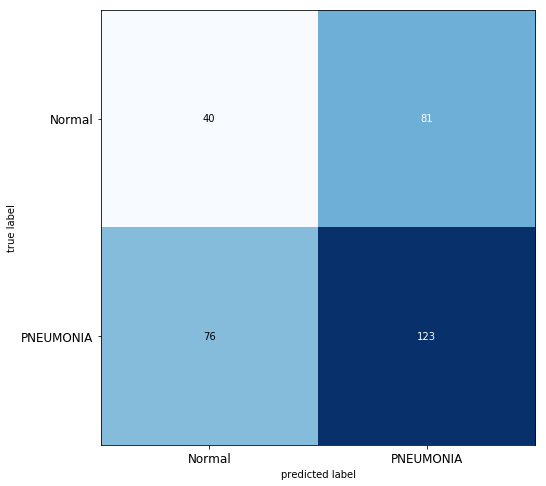

array([[ 40,  81],
       [ 76, 123]], dtype=int64)

In [52]:
print_report=True

y_preds, y_classes, CM, CM_report = predict_report(model, test_generator, classes, print_report)

accuracy, loss =  model_evaluate(model, test_generator, print_report)

show_confusion_matrix(test_generator, y_classes, classes)

## Training Base Model for Fine-Tuning

In [59]:
# train inception model
# fine-tuning the top layers
# compile model with loss, optimizer and metrics 

epochs=100
optimizer=optimizers.adam(lr=0.000001, decay=1e-6)
model.compile(optimizer, loss=loss, metrics=metrics)
tensorboard.set_model(model) 


history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weight)
 

Epoch 1/100
82/82 [==============================] - 157s 2s/step - loss: 0.5078 - mean_absolute_error: 0.2512 - acc: 0.8779 - val_loss: 0.9997 - val_mean_absolute_error: 0.3590 - val_acc: 0.6375
Epoch 2/100
82/82 [==============================] - 128s 2s/step - loss: 0.4718 - mean_absolute_error: 0.2345 - acc: 0.8857 - val_loss: 1.0292 - val_mean_absolute_error: 0.3546 - val_acc: 0.6469
Epoch 3/100
82/82 [==============================] - 122s 1s/step - loss: 0.4399 - mean_absolute_error: 0.2202 - acc: 0.8933 - val_loss: 1.1758 - val_mean_absolute_error: 0.3716 - val_acc: 0.6125

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 4/100
82/82 [==============================] - 121s 1s/step - loss: 0.4295 - mean_absolute_error: 0.2100 - acc: 0.8944 - val_loss: 1.0839 - val_mean_absolute_error: 0.3469 - val_acc: 0.6406
Epoch 5/100
82/82 [==============================] - 127s 2s/step - loss: 0.4231 - mean_absolute_error: 0.2102 - acc: 0.9011 - val_loss

KeyboardInterrupt: 

### Model Performance Visualization over the Epochs

In [60]:
plot_val=[['acc', 'val_acc'], ['loss', 'val_loss']]

title = ['Model accuracy', 'Model loss']

xlabel = ['Epoch', 'Epoch']
ylabel = ['Accuracy', 'Loss']

legend = ['Train', 'Val']

fig_size=(14, 5)


title_fontsize=17
label_fontsize=15

plot_history(history, plot_val, title, xlabel, ylabel, fig_size=fig_size, title_fontsize=title_fontsize, label_fontsize=label_fontsize)

NameError: name 'history' is not defined

## Test Performance of All Models on Test Dataset

Model No: 1
Model File: base-42-val_acc-0.65-val_loss-0.63.hdf5
********************************************************************************


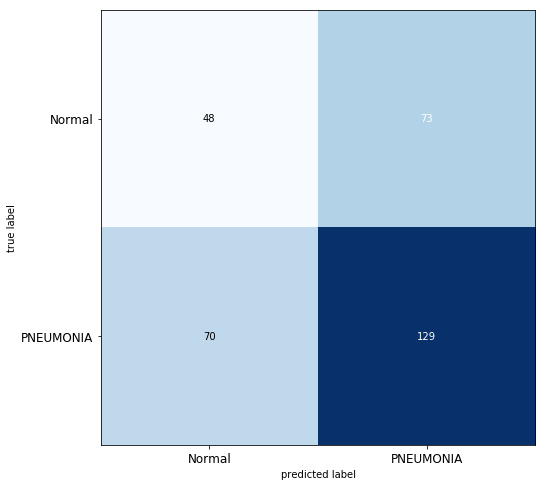

             precision    recall  f1-score   support

     Normal       0.41      0.40      0.40       121
  PNEUMONIA       0.64      0.65      0.64       199

avg / total       0.55      0.55      0.55       320

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [ ]:
details = True
# report_type = "Acc_Loss"
report_type = "Complete"

results=test_all_models(model_dir, details, report_type, classes)

### Visualization of  Performance Over All Epochs/Models based on Accuracy and Loss

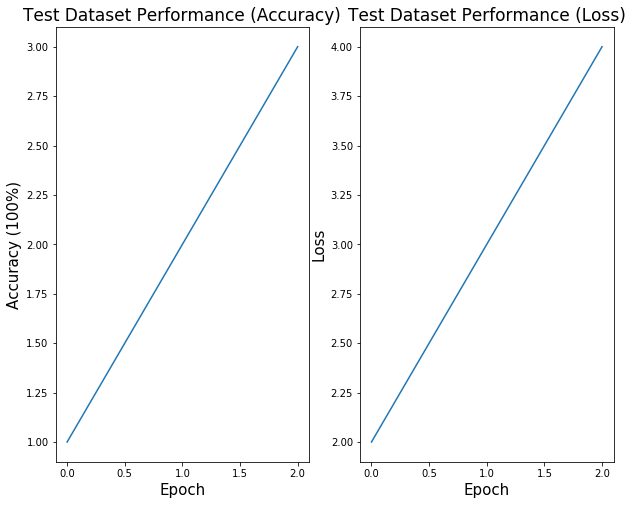

In [63]:
array=[[1,2,3],[2,3,4]]

fig_size = (10, 8)
title=["Test Dataset Performance (Accuracy)", "Test Dataset Performance (Loss)"]
xlabel=["Epoch", "Epoch"]
ylabel=["Accuracy (100%)", "Loss"]

line_plot_over_epochs_loss_acc(array, title, fig_size=fig_size, xlabel=xlabel, ylabel=ylabel, title_fontsize=title_fontsize, label_fontsize=label_fontsize)

# Retraining Best Model

In [ ]:
# reset_callbacks(checkpoint, reduce_lr, early_stopping, tensorboard)
# reset_graph(model)

## Configuration for Retraining

In [ ]:
model_file=model_dir+"retrain-{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

### Full model training parameter configuration for Loss, Optimizer and Performance Metrics

# optimizer
# adam lr=0.01/0.001/0.0001/0.00001/0.000001, decay = decay=1e-5/ 1e-6
optimizer=optimizers.Adam()


# loss function
# loss='binary_crossentropy'
loss='categorical_crossentropy'


# performance metrics ('accuracy', 'binary_accuracy', precision, recall)
metrics=['accuracy']


### Main model training parameter configuration

# epochs = 20/30/50
epochs=30

# steps
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

# verbose 0=nothing 1=each line
verbose=0


#### Configuration for Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard

# checkpoint
ck_monitor='val_acc'
ck_verbose=0
ck_save_best_only=False
ck_save_weights_only=False
ck_mode='auto'
ck_period=1

# ReduceLROnPlateau
red_lr_monitor='val_loss'
red_lr_factor=0.1 # default
# red_lr_patience=5
red_lr_patience=2
red_lr_verbose=1
red_lr_mode='auto'
red_lr_min_delta=0.0001
red_lr_cooldown=0
# red_lr_min_lr=0.0001 # default
red_lr_min_lr=0.000001


# early_stopping
es_monitor = 'val_loss'
es_min_delta=0
# es_patience=0
es_patience=5
es_verbose=0
es_mode='auto'
es_baseline=None

# tensorboard
tb_histogram_freq=0
tb_batch_size=batch_size
tb_write_graph=True
tb_write_grads=False
tb_write_images=False
tb_embeddings_freq=0
tb_embeddings_layer_names=None
tb_embeddings_metadata=None
tb_embeddings_data=None

################################################ Retrain #########################################################
epochs=epochs+1
##################################################################################################################

### Setup Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard for Retraining Best Model

In [ ]:
checkpoint = ModelCheckpoint(model_file, monitor=ck_monitor, verbose=ck_verbose, save_best_only=ck_save_best_only, save_weights_only=ck_save_weights_only, mode=ck_mode, period=ck_period)

reduce_lr = ReduceLROnPlateau(monitor=red_lr_monitor, factor=red_lr_factor, patience=red_lr_patience, verbose=red_lr_verbose, mode=red_lr_mode, min_delta=red_lr_min_delta, cooldown=red_lr_cooldown, min_lr=red_lr_min_lr)

early_stopping = EarlyStopping(monitor=es_monitor, min_delta=es_min_delta, patience=es_patience, verbose=es_verbose, mode=es_mode, baseline=es_baseline)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=tb_histogram_freq, batch_size=tb_batch_size, write_graph=tb_write_graph, write_grads=tb_write_grads, write_images=tb_write_images, embeddings_freq=tb_embeddings_freq, embeddings_layer_names=tb_embeddings_layer_names, embeddings_metadata=tb_embeddings_metadata, embeddings_data=tb_embeddings_data)

In [ ]:
callbacks = [checkpoint, reduce_lr, tensorboard]
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

## Retraining Best Model
### Selecting best model file based on validation accuracy mentioned in file names

In [ ]:
# selecting best model file / checkpoint for retraining
# model_path = model_dir+r"12-val_acc-0.70-val_loss-1.09.hdf5"
# model_path = model_dir+r"20-val_acc-0.66-val_loss-1.97.hdf5"

# best accuracy/ F-1 score
# model_path = "data/output/models/"+"17-val_acc-0.82-val_loss-0.42.hdf5"

# Lowest validation Loss
# model_path = "data/output/models/"+"12-val_acc-0.70-val_loss-1.09.hdf5"

# Best Recall
# model_path = "data/output/models/"+"20-val_acc-0.66-val_loss-1.97.hdf5"

model_path = model_dir+r"20-val_acc-0.71-val_loss-1.26.hdf5"

model = keras.models.load_model(model_path)

# train inception model
# fine-tuning the top layers
# compile model with loss, optimizer and metrics 
model.compile(optimizer, loss=loss, metrics=metrics)
tensorboard.set_model(model) 

# retrain by loading last good model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    # verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weight,
    initial_epoch=initial_epoch)
 

In [ ]:


def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id



test_filenames = test_generator.filenames
df_preds = pd.DataFrame(predictions, columns=classes)
df_preds['file_names'] = test_filenames
df_preds['id'] = df_preds['file_names'].apply(extract_id)
df_preds.head()

# Get the true labels
y_true = test_generator.classes

# Get the predicted labels as probabilities
y_pred = df_preds['Cancer']

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

roc_auc_score(y_true, y_pred)


In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 
submission.head()

##### Retriving actual labels 

In [ ]:
label_map = (test_generator.class_indices)
label_map_rev = {v: name_correct(k) for k,v in label_map.items()}
num_batch_t = len(test_generator)
print(label_map)
print(label_map_rev)

##### Showing accuracy for Model over Single Batch of Test Dataset

In [ ]:
num = random.randint(0, num_batch_t-1)
y_img_batch, y_class_batch = test_generator[num] 
y_pred = np.argmax(model.predict(y_img_batch),-1)
y_true = np.argmax(y_class_batch,-1)
print("Selected Batch No: %d\nBatch Size: %d"%(num, len(y_pred)))
print("Accuracy : ", sum(y_pred==y_true)/batch_size*100, "%")

y_true_labels = [label_map_rev[c] for c in y_true]
y_pred_labels = [label_map_rev[c] for c in y_pred]
batch_size_t = len(y_true_labels)

### Visualization 
Visualization of performance of a random test dataset batch and few random images from a batch

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

Setting parameters for visualization 1

In [ ]:
figure_directory = "data/output/figures"
image_file_name = figure_directory+"/result"

dpi=100

update_image = True


cols = 8
rows= batch_size_t/cols
if batch_size_t%cols==0:
    rows = int(batch_size_t/cols)
else:
    rows = int(batch_size_t/cols)+1
    
figsize_col = cols*2.5
figsize_row = rows*2.5

hspace = 0.5
wspace = 0.3

facecolor='w'
edgecolor='k'

titlesize = 'small'

true_prediction_label_color='black'
false_prediction_label_color='red'

true_label_title_prefix = "org : "
pred_label_title_prefix = "pred: "

if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

In [ ]:
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_col, figsize_row),
                        dpi=dpi, facecolor=facecolor, edgecolor=edgecolor,
                        subplot_kw={'xticks': [], 'yticks': []})


plt.rcParams.update({'axes.titlesize': titlesize})
plt.subplots_adjust(hspace=hspace, wspace=wspace)

for i in range(0, batch_size_t): # how many imgs will show from the mxn grid
    plt.subplot(rows, cols, i+1)
    
    plt.imshow(y_img_batch[i])
    
    plt.xticks([])
    plt.yticks([])
    
    if y_true_labels[i]==y_pred_labels[i]:
        plt.title(true_label_title_prefix + y_true_labels[i] + "\n" + pred_label_title_prefix + y_pred_labels[i])
    else:
        plt.title(true_label_title_prefix + y_true_labels[i] + "\n" + pred_label_title_prefix + y_pred_labels[i], color=false_prediction_label_color)
        
    if update_image and os.path.exists(image_file_name):
        os.remove(image_file_name)
    
    fig.savefig(image_file_name, dpi=dpi)

plt.tight_layout()
plt.show()

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

Setting parameters for visualization 2

In [ ]:
figure_directory = "data/output/figures"
image_file_name = figure_directory+"/sample"

dpi=100

update_image = True

cols = 4
rows= 2

count = rows*cols
    
figsize_col = cols*2.5
figsize_row = rows*2.5

hspace = 0.5
wspace = 0.3

# titlesize = 'small'

true_prediction_label_color='black'
false_prediction_label_color='red'

true_label_title_prefix = "org:  "
pred_label_title_prefix = "pred: "

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

In [ ]:
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_col, figsize_row),
                        dpi=dpi, facecolor=facecolor, edgecolor=edgecolor,
                        subplot_kw={'xticks': [], 'yticks': []})

plt.rcParams.update({'axes.titlesize': titlesize})
plt.subplots_adjust(hspace=hspace, wspace=wspace)


batch_size_tmp = batch_size_t

m = {}

for i in range(0, count): 
    num = random.randint(0, batch_size_tmp-1)
    while num in m:
        num = random.randint(0, batch_size_tmp-1)
    
    m[num]=1
    
    plt.subplot(rows, cols, i+1)
    
    plt.imshow(y_img_batch[num])
    
    plt.xticks([])
    plt.yticks([])
    
    if y_true_labels[num]==y_pred_labels[num]:
        plt.title(true_label_title_prefix + y_true_labels[num] + "\n" + pred_label_title_prefix + y_pred_labels[num])
    else:
        plt.title(true_label_title_prefix + y_true_labels[num] + "\n" + pred_label_title_prefix + y_pred_labels[num], color=false_prediction_label_color)
    
   
    if update_image and os.path.exists(image_file_name):
        os.remove(image_file_name)   
    
    fig.savefig(image_file_name, dpi=dpi)


plt.tight_layout()
plt.show()